```
  /$$$$$$  /$$   /$$ /$$$$$$$   /$$$$$$ 
 /$$__  $$| $$  | $$| $$__  $$ /$$__  $$
| $$  \__/| $$  | $$| $$  \ $$| $$  \ $$
|  $$$$$$ | $$  | $$| $$  | $$| $$  | $$
 \____  $$| $$  | $$| $$  | $$| $$  | $$
 /$$  \ $$| $$  | $$| $$  | $$| $$  | $$
|  $$$$$$/|  $$$$$$/| $$$$$$$/|  $$$$$$/
 \______/  \______/ |_______/  \______/ 


 @Author : Pierre Lague

 @Email : p.lague@sudogroup.fr

 @Date : 04/10/2024

```

## Time Series forecasting with TPOT and XGBoost

>@author Pierre Lague

In this notebook we will walk through time series forecasting using an XGBoost model at first and then automate the process with a TPOT pipeline. **The data we will be using is hourly energy consumption which resonates with the kind of data we'll be using on cloud resource consumption (on an hourly basis).**

> A time series is a sequence of data with a time dimension that is directly correlated to the value of the data

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting and information display
import xgboost as xgb # our baseline classifier for this notebook
from xgboost import plot_importance # feature importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import os

plt.style.use('fivethirtyeight')

### Data Exploration

In [16]:
file_path = os.path.join("./data/AEP_hourly.csv")
pjme = pd.read_csv(file_path, index_col=[0], parse_dates=[0])

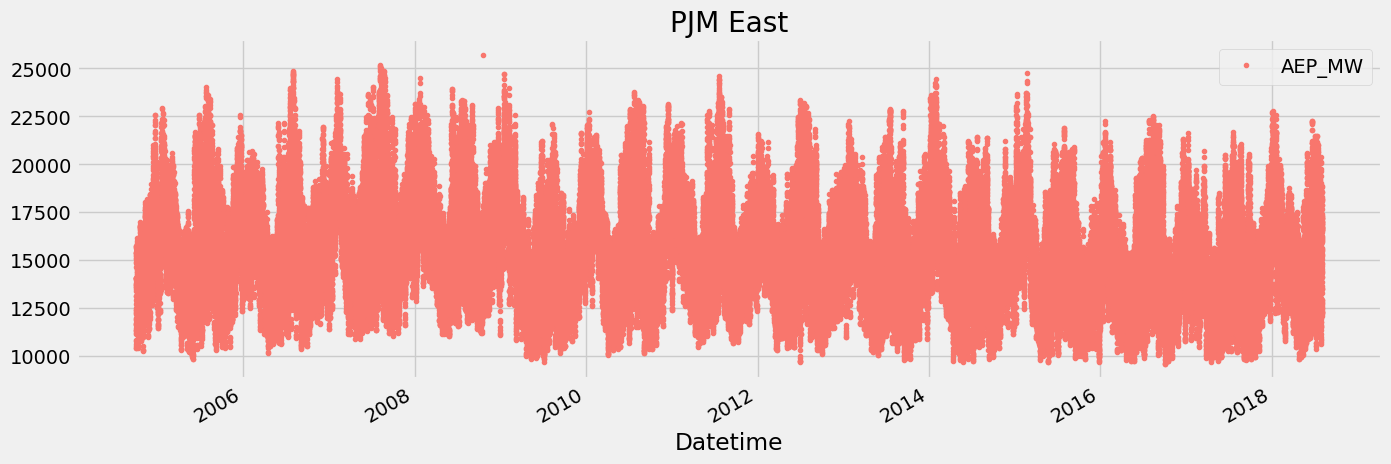

In [17]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

### Train/Test Split

Splitting time series can be tricky. They are not like other data, because they have to be analyzed in a linear fashion. Of course we wouldn't want the year 2013 to be analyzes before the year 2009 if we randomize the elements ?

So we pick a date on sight. According to the plot, 70% of the data seems to be recorded before 2015, so we'll split on the 1st of January 2015. That way we have two datasets `pjme_train`and `pjme_test` of containing each roughly 70% of the data and 30% of the data.

In [18]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

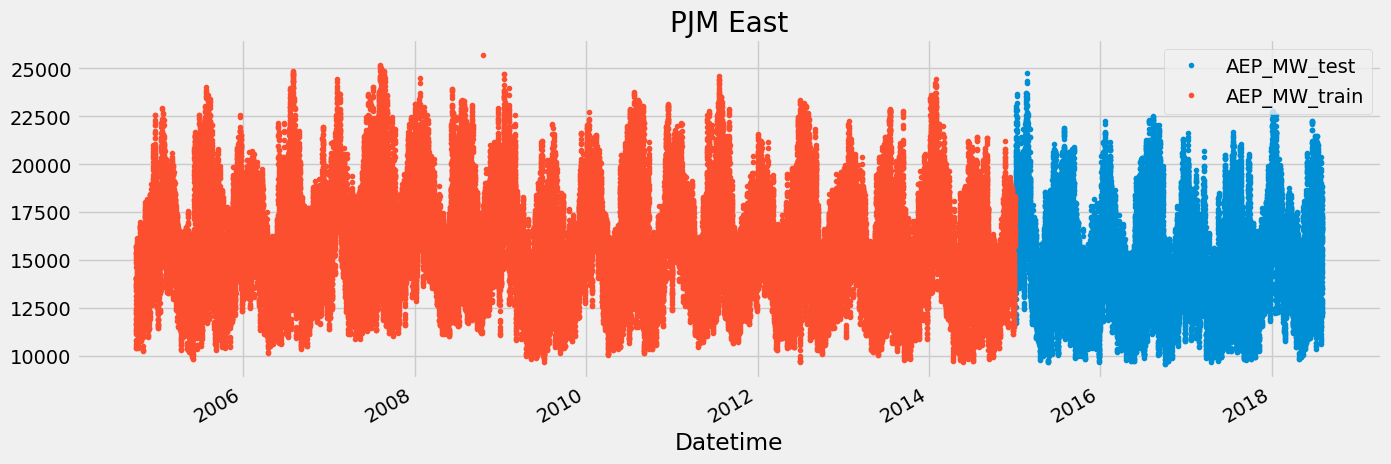

In [19]:
_ = pjme_test.rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer', lsuffix='_test', rsuffix="_train") \
    .plot(figsize=(15,5), title='PJM East', style='.')

We have displayed our two datasets train and test for our analysis. it's important to keep in mind that time series datasets have to be analyzed and processed linearly because of the correlation between the value observed and time. If they are dissociated, the data won't make any sense.

## Creating time series feature to work on

What we're doing here is creating seasonalities and periods. Basically making the data more granular and interesting. From a datetime index we can get hours, days of week, quarters, months, years etc. All these attributes will have their importance in our model afterwards.

In [20]:
y = pjme_train["AEP_MW"] #we're defining our target variable for our forecasting model

Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
                        ...   
2014-01-01 20:00:00    16433.0
2014-01-01 21:00:00    16376.0
2014-01-01 22:00:00    16151.0
2014-01-01 23:00:00    15687.0
2014-01-02 00:00:00    15201.0
Name: AEP_MW, Length: 89834, dtype: float64

In [21]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [22]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')
X_test, y_test = create_features(pjme_test, label='AEP_MW')

To recap, in X_train we have :
- date
- hour
- dayofweek
- quarter
- month
- year
- dayofyear
- dayofmonth

All time informations that will help us forecast y_train which contains the values of energy consumption

**All this from beginning to 1ST JAN 2015** the rest is in `X_test`, `y_test` and has the same structure.


### Create XGBoost Model

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It has proven itself quite adapted to time series forecasting.
You can find more information about XGBoost [here](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)

In [23]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Our model is pretty basic since we didn't seek any hyperparameter optimisation. (we will automate this with TPOT later on).

### Feature Importance

A good thing about XGBoost that differs from more "overkill" methods like deep learning (LSTM, RNN) for time series forecasting is that it's fully explainable. Where in deep learning we have no way of really knowing which attribute is the most important (because of the "black box" aspect of neural network), XGBoost offers good insight of the feature importance.

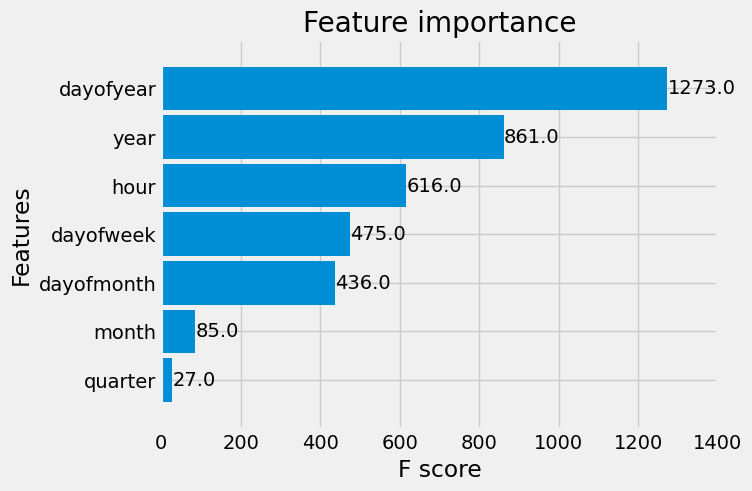

In [24]:
_ = plot_importance(reg, height=0.9)


**Using this technique and kind of plot we would be able to explain to the client the importance of each feature in our forecasting leading to the forecasted value. This would bring significant insight for us and our the recommendations we would give the client for its future use of certain resources.**

### Forecasting on test set

Now that we have our model it's time to test it and evaluate its quality. We can have a first look visualy to assert the models ability to forecast the energy consumption.

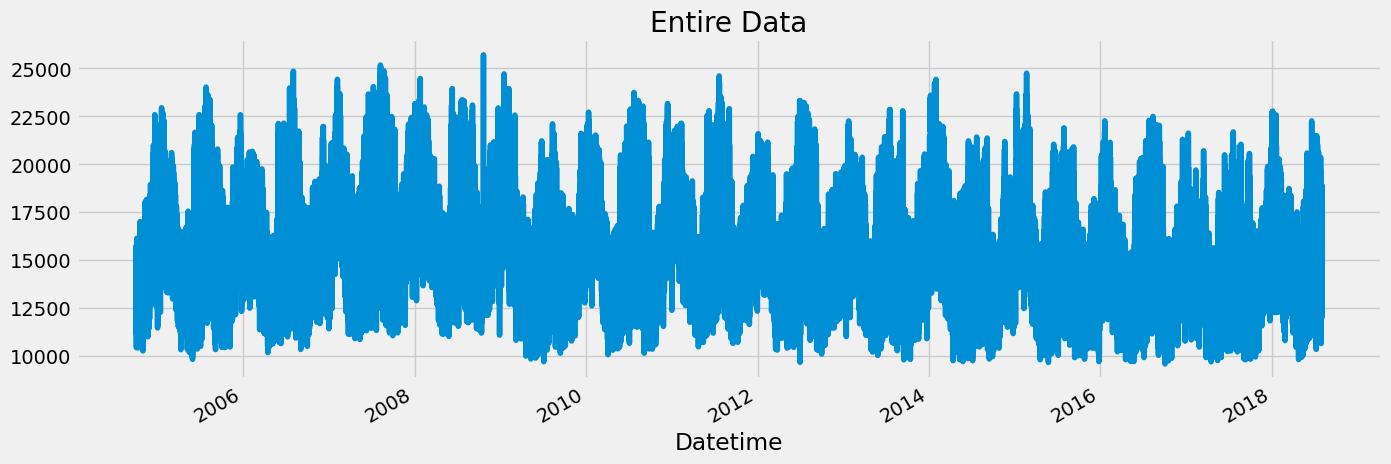

In [30]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pjme_train.combine_first(pjme_test)
_ = pjme_all["AEP_MW"].plot(figsize=(15, 5), title="Entire Data")

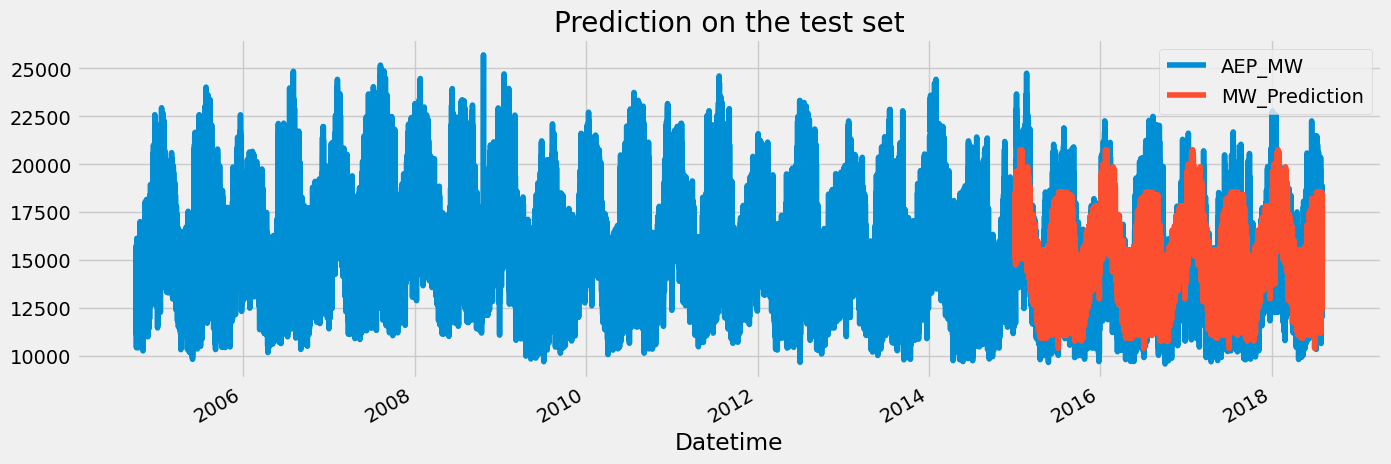

In [31]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5), title="Prediction on the test set")

Overall we can agree that our model is *able* to predict the global trends in the data. What's interesting is that we can observe a cyclic pattern in the prediction where the model alternates between a good forecasting and a not so good one.



here are more granular predictions over a single month

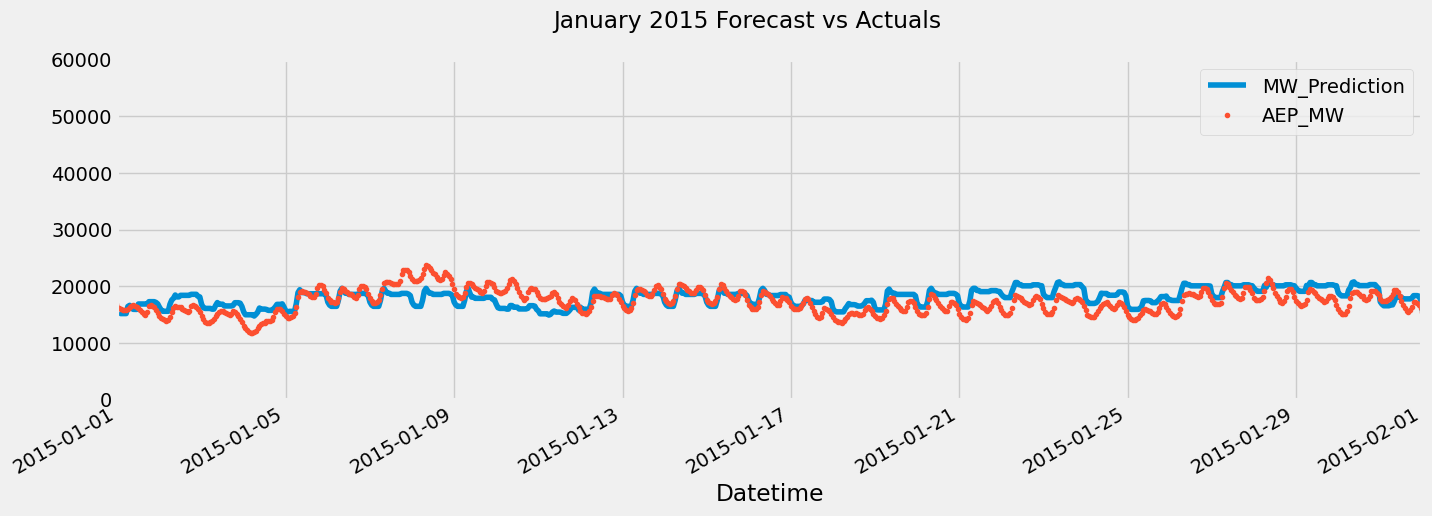

In [50]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

For a month of forecasting, the predictions are quite good.

over a week

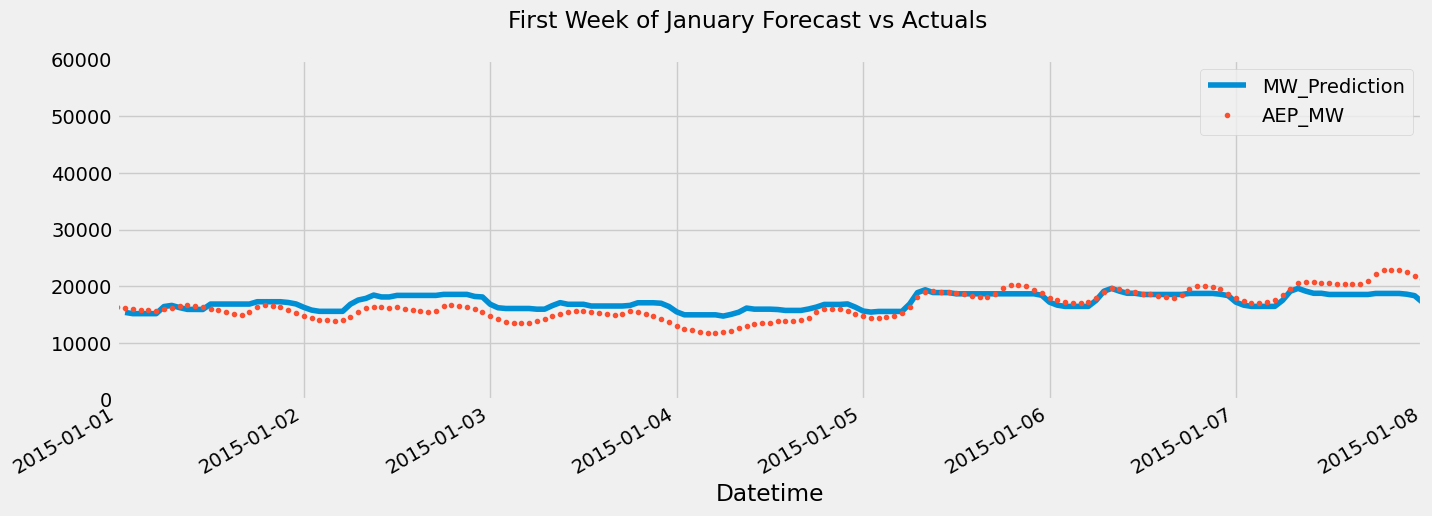

In [51]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

over the first week of july

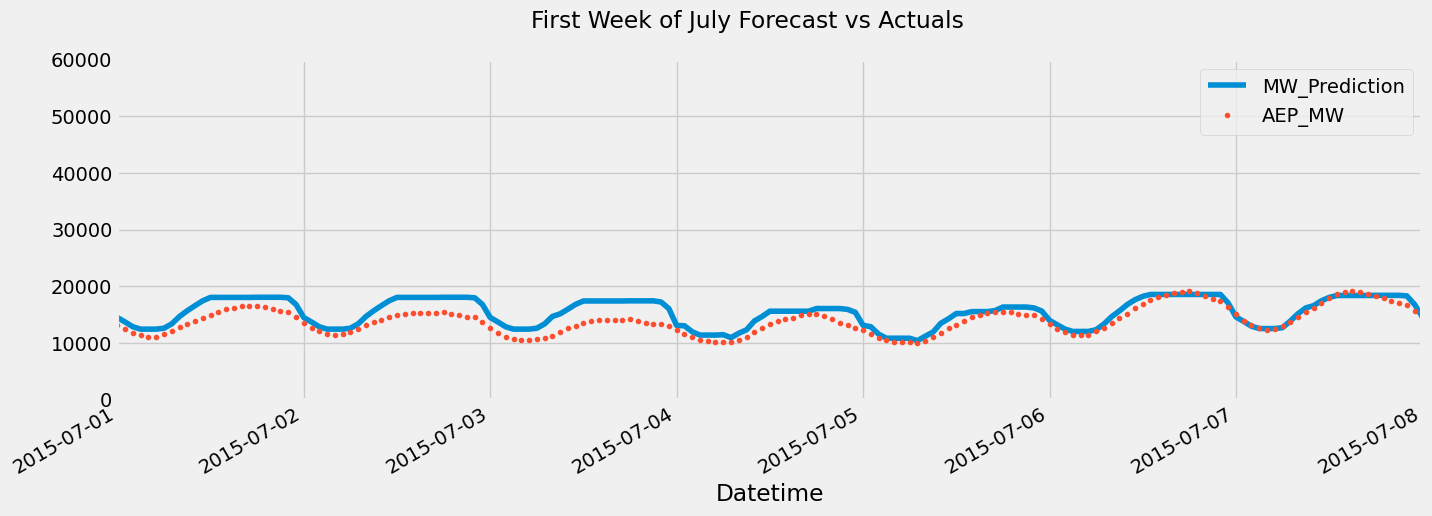

In [52]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

Overall, when delving into a more granular version of the dataset, we can see that the predictions are very close to the ground truth data. And in our case (forecasting of the energy consumption or cost) we will need precise data on a granular level, and settle for a compromise of a more "approximate" forecasting when we're looking at months or years.

## Evaluating the model

We evaluate a model with metrics. Here we will measure the error, because we want it to be as little as possible. We evaluate it on the test set.
The metrics are hard to evaluate 

In [53]:
mean_squared_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2953893.302826179

In [54]:
mean_absolute_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

1365.3497249572088

In [55]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

0.09373152324932883

The MAPE (Mean Average percentage Error) measures the average percentage difference between the actual values and predicted values.
Here, on the whole test set, we have a mean average  of 9% error which is pretty good for a model we trained for only a few minutes without optimizing the parameters.

## Time Series using TPOT

Now we're going to try and use TPOT on our data. We have to remember :

**THIS IS VERY VERY IMPORTANT**
- target variable needs to be named `class`
- each variable has to be numerical
- we are doing a regression

TPOT is very practical when it comes to hyperparameter tuning, it automates various generations of training over a range of hyperparameter values as well as various type of models ranging from decision trees (regression) to SVM (classification).



In [32]:
from tpot import TPOTRegressor

pjme_train = pjme_train.rename(columns={"AEP_MW":"class"})
pjme_test = pjme_test.rename(columns={"AEP_MW":"class"})

In [33]:
def get_numeric_date(df):
    df["date_numeric"] = df["date"].values.astype(np.int64) // 10**9
    df = df.drop(columns=["date"])
    return df

pjme_train_numeric = get_numeric_date(pjme_train)
pjme_test_numeric = get_numeric_date(pjme_test)

pjme_test_numeric.dtypes

class            float64
hour               int32
dayofweek          int32
quarter            int32
month              int32
year               int32
dayofyear          int32
dayofmonth         int32
MW_Prediction    float32
date_numeric       int64
dtype: object

building our train and test sets.
- X_* will contain the features on which the model will learn representations and patterns
- y_* is our target variable (the energy consumption)

**N.B. for TPOT X and y must be np arrays, but most of the models won't require this (most of th etime you can just pass the dataframe). Only this time we will get the values of each df**

In [34]:
y_train = pjme_train_numeric["class"]
X_train = pjme_train_numeric.drop(columns=["class"])
y_test = pjme_test_numeric["class"]
X_test = pjme_test_numeric.drop(columns=["class", "MW_Prediction"])


**DON'T FORGET TO CHANGE THE `max_time_mins` parameter if you don't want the training to be too long. Cross validation on different models and parameter values can be rather long.**

The model will stop at the end unless counter indicated by the early_stopping parameter.

In [35]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, cv=3, max_time_mins=5) #setting a max time of 5 Minutes, default is 10. 
tpot.fit(np.array(X_train.values), np.array(y_train.values).ravel())

                                                                            
5.15 minutes have elapsed. TPOT will close down.                            
TPOT closed during evaluation in one generation.
                                                                            
                                                                            
TPOT closed prematurely. Will use the current best pipeline.
                                                                            
Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.6000000000000001, min_samples_leaf=16, min_samples_split=2, n_estimators=100)


TPOTRegressor(cv=3, generations=5, max_time_mins=5, population_size=20,
              verbosity=2)

Interestingly, the model that came out with the best performance is `ExtraTreesRegressor`.

The **ExtraTreesRegressor** is an ensemble learning method that builds multiple decision trees to improve regression predictions through the principles of bagging and randomness. It trains each tree on a random subset of the data and considers a random subset of features at each split, which enhances model diversity and reduces overfitting. Unlike some other tree-based algorithms, Extra Trees does not prune the trees after construction, allowing for deeper trees that capture complex patterns in the data. Predictions are made by averaging the outputs of all trees, resulting in a robust and efficient model that typically performs well in various regression tasks while being faster to train than alternatives like Random Forests. Its key hyperparameters include the number of trees, the maximum number of features to consider for splits, and constraints on tree depth and leaf nodes, allowing for flexibility in controlling model complexity.

In [39]:
# tpot.export('TPOT_time_series_pipeline.py')  # we can export our pipeline for development automation i commented it out but feel free to use it.

## Making predictions on the test set

In [40]:
X_test['MW_Prediction'] = tpot.predict(np.array(X_test.values))

In [41]:
X_train["AEP_MW"] = y_train
X_test["AEP_MW"] = y_test

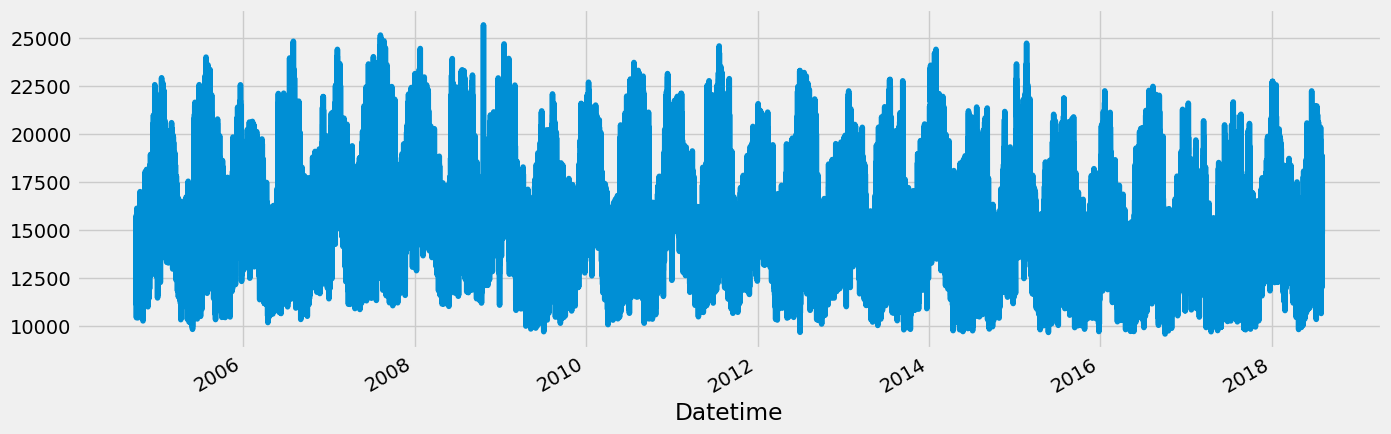

In [42]:
pjme_all_numeric = X_train.combine_first(X_test)
_ = pjme_all_numeric["AEP_MW"].plot(figsize=(15, 5))

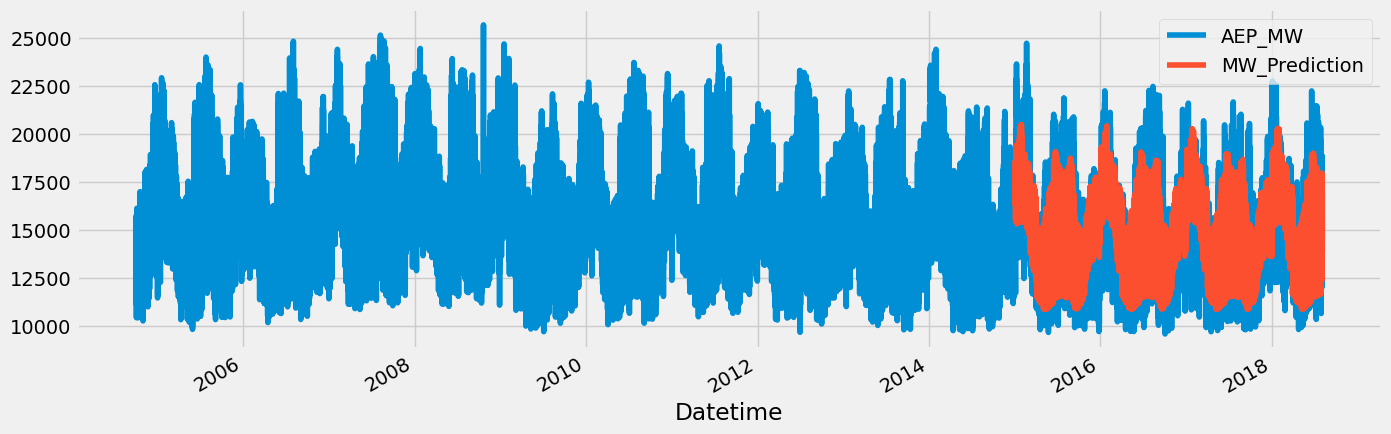

In [43]:
_ = pjme_all_numeric[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))


We can see that the TPOT model has much better range of forecasting on the peak values in the test set. And this was achievable with just a few minutes training. 

Again, we can have more granular displays

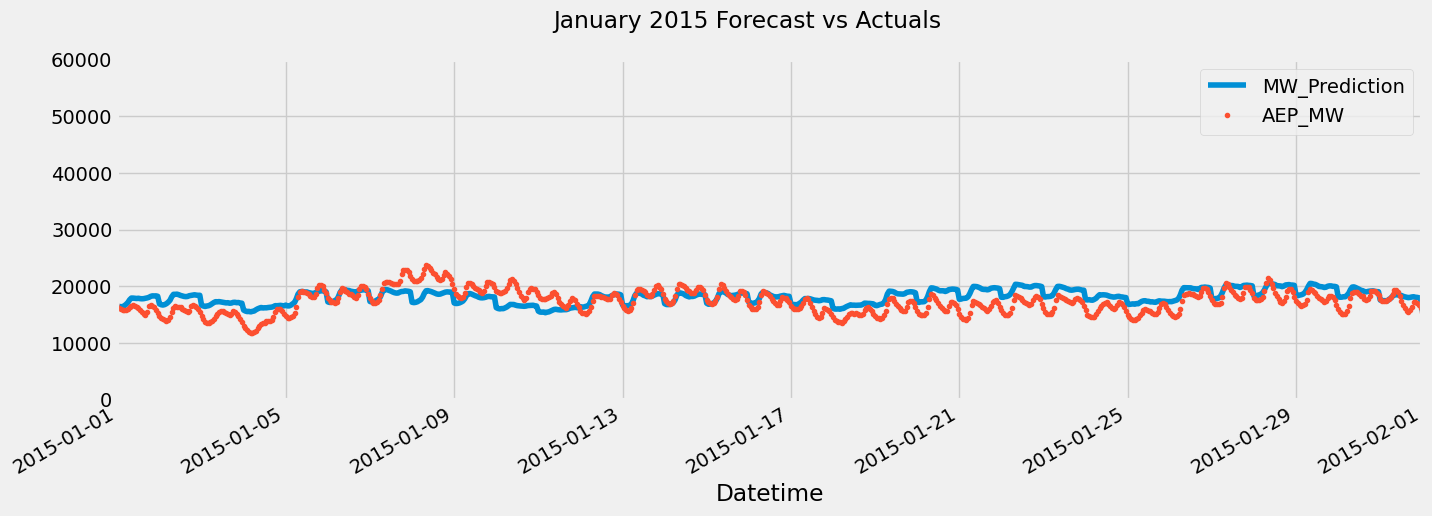

In [44]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all_numeric[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

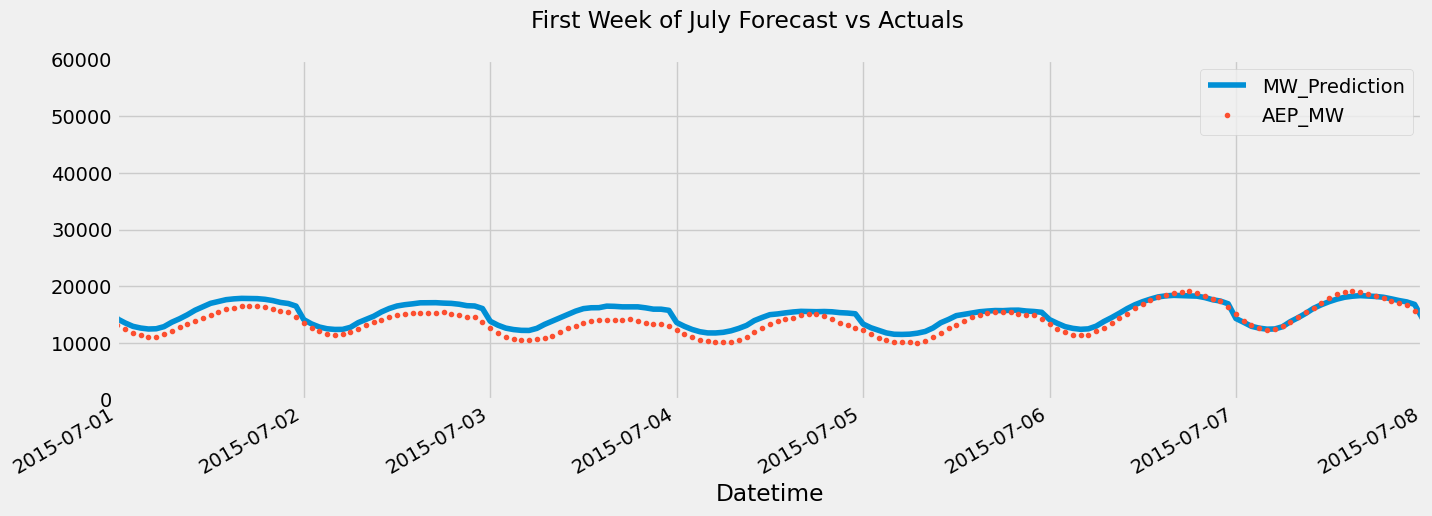

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all_numeric[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

Our TPOT model is able to accuratly forecast time series data with only 5 minutes of training.

## Evaluating the model with metrics

As we did previously for our xgboost model, we can evaluate our model with metrics such as the MAE, MAPE etc. to assert its quality.

In [46]:
mean_absolute_percentage_error(y_true=X_test['AEP_MW'],
                   y_pred=X_test['MW_Prediction']) #here's the MAPE

0.09192875271981193

With the TPOT pipeline we're able to reach 9% mean average percentage error which is not bad either, but could be improved with a better parametrized TPOT instanciation.

**N.B.** I've tried cutting the data we have in order to see which was the threshold of data we could use to have a consistent model, and i came to the conclusion that if we need to analyze hourly basis data, we need at least 3 months for an interesting model.


The results are also quite promising when it comes to explainable AI and avoiding black box models that aren't really interpretable. Moreover we won't need huge resources using these lightweight models. The only issue is the amount of data (but is it not always) that needs to be processed and put through training.